In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from dateutil import parser
from itertools import repeat

The purpose of this exercise is to better understand the March Madness tournament, with the goal of helping us to make better
decisions when filling out a tournament bracket and (hopefully!) helping us to win some of our co-workers' money. This notebook
is based _solely_ on seed matchup analysis. There is no modeling and minimal feature engineering involved. In another post
I may go into detail exploring the characteristics of underdogs-that-win vs favorites-that-lose, but for now I want to 
document in never-before-seen-detail the kinds of things to look for in terms of seed analysis that the average basketball
fan can use in upcoming tournaments. No understanding of machine learning necessary, and hopefully we can learn some cool
insights. I used exactly this analysis when I was filling out my 2019 bracket, and with my findings I was able to call 
Auburn making the Final Four ([only 3.9% of brackets saw this coming by the way](https://watchstadium.com/news/auburn-texas-tech-purdue-among-best-2019-ncaa-tournament-bracket-picks-03-31-2019/))
As we walk through this notebook I'll take you through my thought process as I was designing the bracket that won second place
in a pool of 100+ contestants, and first place in a pool of 60+.

First things first, I pulled historical NCAA data conveniently hosted kaggle's website (apparently march madness is a topic ripe
with the attentions of fellow data scientists. I've popped the data file up on github so the avid readers can follow along if
inspiration strikes.

In [83]:
# I always start by taking a quick look at the data set
data = pd.read_csv('ncaa_data.csv')
data.head()

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed
0,1985,1,1,West,1,83,St Johns,Southern,59,16,NaN
1,1985,1,1,West,2,81,VCU,Marshall,65,15,NaN
2,1985,1,1,West,3,65,NC State,Nevada,56,14,NaN
3,1985,1,1,West,4,85,UNLV,San Diego St,80,13,NaN
4,1985,1,1,West,5,58,Washington,Kentucky,65,12,NaN


I didn't get particularly fancy (and I would argue that you don't need to). I was able to get a high performing bracket
with minimal feature engineering. To start, let's create a column for "winning seed" so we can examine the distribution 
of winners per round. I'm also throwing out the 'Region Number' and 'Region Name' columns as they won't be useful to us.

In [299]:
data['winning_seed'] = np.where(data['score_1']>=data['score_2'], data['seed_1'], data['seed_2'])
data.drop(['Region Number', 'Region Name'], axis=1)
data.head()

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed,favorite,underdog,upset
1134,2003,1,1,Midwest,1,95,Kentucky,IUPUI,64,16,1,1,16,0
1135,2003,1,1,Midwest,2,87,Pittsburgh,Wagner,61,15,2,2,15,0
1136,2003,1,1,Midwest,3,72,Marquette,Holy Cross,68,14,3,3,14,0
1137,2003,1,1,Midwest,4,71,Dayton,Tulsa,84,13,13,4,13,1
1138,2003,1,1,Midwest,5,81,Wisconsin,Weber St,74,12,5,5,12,0


Let's also create an 'upset' column to tell us whether or not a given game
went "as expected"

In [85]:
data['favorite'] = np.where(data['seed_1']<data['seed_2'], data['seed_1'], data['seed_2'])
data['underdog'] = np.where(data['seed_1']<data['seed_2'], data['seed_2'], data['seed_1'])
# account for cases where there is no favorite (ie identical seeds)
data['favorite'] = np.where(data['seed_1'] == data['seed_2'], -1, data['favorite'])
data['underdog'] = np.where(data['seed_1'] == data['seed_2'], -1, data['underdog'])
data['upset'] = np.where(data['winning_seed'] != data['favorite'], 1, 0)
# force games showcasing tied seeds to be '0' in the 'upset' column
data['upset'] = np.where(data['favorite'] == -1, 0, data['upset'])
data.head()

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed,favorite,underdog,upset
0,1985,1,1,West,1,83,St Johns,Southern,59,16,1,1,16,0
1,1985,1,1,West,2,81,VCU,Marshall,65,15,2,2,15,0
2,1985,1,1,West,3,65,NC State,Nevada,56,14,3,3,14,0
3,1985,1,1,West,4,85,UNLV,San Diego St,80,13,4,4,13,0
4,1985,1,1,West,5,58,Washington,Kentucky,65,12,12,5,12,1


The million dollar question when filling out a bracket is, _"to upset, or not to upset?"_ The naive bracket would simply select
higher seeds to defeat lower seeds and result in the number 1 overall seed clinching the title. We can do better. To 
start, the first question I asked is, how common are upsets at different stages of the tournament? Also worth noting is that 
this is a  comprehensive data set spanning back to the beginning of this age old tradition, [1985](https://genius.com/Bowling-for-soup-1985-lyrics)
I assumed that modern day hoops are a different beast from the game during the time of the 45 second [shot clock](https://www.vuhoops.com/2010/07/27/cats-owls-and-the-story-of-the-shot-clock),
so I chose to consider the 16 most recent tournaments from 2003 onward.


In [86]:
data = data.query('Year >= 2003')
data[['upset', 'Round']].groupby(['Round']).agg('sum')

,upset
Round,
1,130
2,74
3,37
4,33
5,6
6,3


It looks like there have been three finals upsets in the 16 year period since 2003. I was curious to look at the total 
upsets each round...

In [87]:
data[['upset', 'Round']].groupby(['Round']).agg('count')

,upset
Round,
1,512
2,256
3,128
4,64
5,32
6,16


But wait! I just thought of something important. Remember, we only want to count games where an upset was _possible_. So we
should really be excluding all rows where favorite = -1 (recall our definition of this earlier, it simply means the game 
showcased two teams of the same seed, so there was no possibility that an upset could even occur).

It looks like there have been 5 finals since 2003 showcasing tied seeds, and 12 final fours showcasing tied seeds. This makes
sense, given the structure of the tournament it would be impossible for a game to feature tied seeds in any of the first four rounds. We'll want
to exclude these "tied seed" games from our 'upset percentage' analysis, since we want to pose the question, "Given that an upset,
_is possible_, how likely is it to occur", and not "how likely is an upset to occur?" It's a subtle difference, but the
distinction could mean the difference between glorious victory and office shame.  

In [88]:
data.query('favorite != -1')[['upset', 'Round']].groupby(['Round']).agg('count')

,upset
Round,
1,512
2,256
3,128
4,64
5,24
6,11


Looking much better. Now that we've excluded games featuring tied seeds, we can merge _actual upsets_ with candidate upset
matches. There is probably a more pythonic way to do this, I am currently accepting pull requests :)

In [300]:
# Since 2003
all_potentially_upset_games = data.query('favorite != -1')[['upset', 'Round']].groupby(['Round']).agg('count')
all_upsets = data[['upset', 'Round']].groupby(['Round']).agg('sum')
upset_pct = pd.concat([all_potentially_upset_games, all_upsets], axis=1, ignore_index=True)
upset_pct = upset_pct.rename(columns = {0: "upset_candidates", 
                                  1:"actual_upsets" 
                                  })
upset_pct['upset_pct'] = upset_pct['actual_upsets']/upset_pct['upset_candidates']
upset_pct

,upset_candidates,actual_upsets,upset_pct
Round,,,
1,512,130,0.253906
2,256,74,0.289062
3,128,37,0.289062
4,64,33,0.515625
5,24,6,0.250000
6,11,3,0.272727


Well what do we have here? Honestly, I would have expected to see more upsets early on and fewer upsets later on in the 
tournament. Shockingly though, historical upset rates are pretty constant, hovering around the 25% mark. But in the elite eight
(round 5) that stat essentially doubles to 50% ! This is an important observation for those of us working on filling out a 
bracket --it means that we may want to think about choosing a few extra upsets in the elite eight. Side note, this year Duke, 
Gonzaga, and Kentucky all sufferred elite eight losses (75% of games resulted in upsets.) Seems like a pretty powerful insight 
to me!

The next thing I want to look at is a distribution of winning seeds by round. It's all well and good to be looking at upset
rates, but our task is to select _the right_ upsets. So we have to be smart about where we lay down our cards.

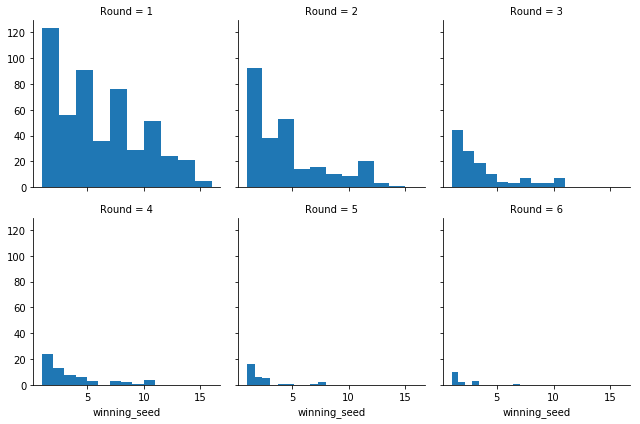

In [72]:
g = sn.FacetGrid(data, col="Round", col_wrap = 3)
g.map(plt.hist, "winning_seed");

In [77]:
data.query('Round == 6')

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed,favorite,upset
1196,2003,6,1,Championship,2,78,Kansas,Syracuse,81,3,3,2,1
1259,2004,6,1,Championship,3,73,Georgia Tech,Connecticut,82,2,2,2,0
1322,2005,6,1,Championship,1,70,Illinois,North Carolina,75,1,1,-1,0
1385,2006,6,1,Championship,2,57,UCLA,Florida,73,3,3,2,1
1448,2007,6,1,Championship,1,84,Florida,Ohio St,75,1,1,-1,0
1511,2008,6,1,Championship,1,75,Kansas,Memphis,68,1,1,-1,0
1574,2009,6,1,Championship,2,72,Michigan St,North Carolina,89,1,1,1,0
1637,2010,6,1,Championship,5,59,Butler,Duke,61,1,1,1,0
1700,2011,6,1,Championship,3,53,Connecticut,Butler,41,8,3,3,0
1763,2012,6,1,Championship,1,67,Kentucky,Kansas,59,2,1,1,0


Let's take a second to understand what we're looking at here. We have a nice distribution broken out by round looking
at winning seeds throughout the tournament. In the finals specifically, we can see that 3 seeds have bested a 2-seed twice,
and a 2 seed overthrew a mighty 1-seed once in 2016. I'd like to see a heatmap informing _which_ upset matchups are the 
most common (how likely is a 13 seed to displace a 4 seed vs a 5 seed over a 4 seed for example?) Luckily seaborn has a 
nice heatmap functionality we can take advantage of in order to visualize this.

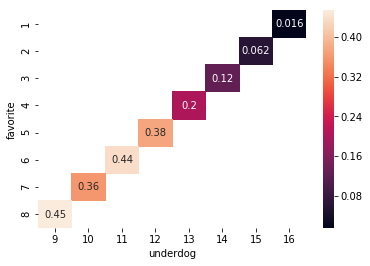

In [313]:
# Let's focus on Round 1
favs = [1, 2, 3, 4, 5, 6, 7, 8]
underdogs = [16, 15, 14, 13, 12, 11, 10, 9]
upset_rate = []
occurences = []
round1 = data.query('Round == 1')
for i in range(1,9):
    matchups = round1[round1['favorite'] == i].shape[0]
    upsets = round1[round1['favorite'] == i][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))

round1_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round1_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

In [219]:
# 64 occurences of each matchup is a good sanity check for us to validate that we're doing this right
# looking at a 16 year period, there are 4 regions per tournament, so we would expect to see 16*4 occurences for 
# each initial matchup
round1_upsets.sort_values(by=['upset_rate'], ascending = False)

,favorite,underdog,upset_rate,occurences
7,8,9,0.453125,64.0
5,6,11,0.437500,64.0
4,5,12,0.375000,64.0
6,7,10,0.359375,64.0
3,4,13,0.203125,64.0
2,3,14,0.125000,64.0
1,2,15,0.062500,64.0
0,1,16,0.015625,64.0


In Round 1, it might not be a bad idea to pick your favorite 13 seed to displace a 4 seed (13s win 20% of the time.) 
I would advise just advancing all 1, 2, and 3 seeds through to the round of 32. Spend time choosing likely upsets in the
8 v 9, 7 v 10, 6 v 11, and 5 v 12 realm. If this notebook is popular, I'll write something up about how to detect signals
that would indicate whether a team has a good chance of upsetting an opponent. For this post, we're just looking at how
_many_ of these upsets we want to forecast, and during which rounds and for which matchups we should forecast them. 
We'll talk about how to select from eligible upsets in another post, but the key takeaway from this data is that the best 
"bang for your buck" upset pick is 9 v 8, 
followed closely by 11 v 6.

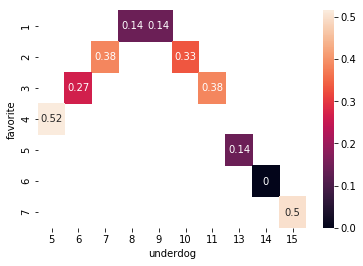

In [312]:
# What about round 2?
favs = [1, 1, 2, 2, 3, 3, 4, 5, 6, 7]
underdogs = [9, 8, 10, 7, 11, 6, 5, 13, 14, 15]
upset_rate = []
occurences = []
round2 = data.query('Round == 2')

for i in range(0, len(favs)):
    
    matchups = round2[(round2.favorite == favs[i]) & (round2.underdog == underdogs[i])].shape[0]
    upsets = round2[(round2.favorite == favs[i]) & (round2.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))

round2_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round2_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

In [308]:
round2_upsets.sort_values(by=['upset_rate'], ascending = False)

,favorite,underdog,upset_rate,occurences
6,4,5,0.515152,33.0
9,7,15,0.500000,2.0
3,2,7,0.384615,39.0
4,3,11,0.384615,26.0
2,2,10,0.333333,21.0
5,3,6,0.266667,30.0
0,1,9,0.142857,28.0
1,1,8,0.142857,35.0
7,5,13,0.142857,7.0
8,6,14,0.000000,6.0


Often when I'm filling out a bracket I get overwhelmed by the amount of reserach I'd need to do to call each game sensically.
Usually I start out with lots of enthusiasm, quickly get overwhelmed, and then somewhat carelessly fill it out for completion
rather than accuracy. This system offers a unique perspective on where to spend your resources. That is, round 2 tells a
slightly different story. Instead of there being fixed matchups known in advance, there are multiple underdogs that could face
a given favorite, and 8 seeds can no longer be favorites in the round of 32. Interestingly, an 1 v 9 upset is equally as
likely as a 1 v 8 upset. Also interesting, 11 seeds upset 3 seeds (38%) more often than 6 seeds (26%)! In the 33 occurences
where a 4 seed has played a 5 seed, 5 seeds actually win slightly more often (51%). The most commonly occuring matchup in 
Round 2 is a 2 v 7 showdown, and 7's take the cake 38% of the time. Some interesting insights! Let's see what we can 
learn from the sweet sixteen.

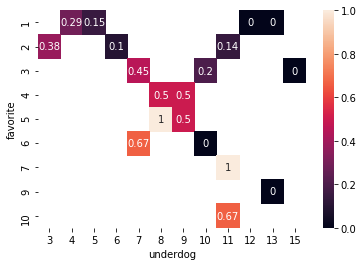

In [311]:
# What about round 3?
round3 = data.query('Round == 3')

favorites = [1, 2, 3, 4,5,6,7,9,10]
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round3[round3['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round3[(round3.favorite == favs[i]) & (round3.underdog == underdogs[i])].shape[0]
    upsets = round3[(round3.favorite == favs[i]) & (round3.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round3_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round3_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

In [289]:
round3_upsets.sort_values(by=['occurences'], ascending = False)

,favorite,underdog,upset_rate,occurences
0,1,4,0.291667,24.0
5,2,3,0.380952,21.0
3,1,5,0.150000,20.0
9,3,7,0.454545,11.0
6,2,6,0.100000,10.0
2,1,12,0.000000,8.0
4,2,11,0.142857,7.0
7,3,10,0.200000,5.0
10,4,8,0.500000,4.0
15,6,7,0.666667,3.0


We're starting to see some data paucity problems in this realm, as our sample size quickly pares down. So we need to be
careful about the inferences we make, especially in cases where seed matchups have occurred only a handful of times in 
history. There are countless factors that can influence upset outcomes, so of course a strictly-seed-based analysis is
a gross oversimplification of the problem. The goal here is just to extract all that we can out of the seed information
at hand. One thing that jumps out at me here is the 3 v 7 matchup -- 7 seeds advance to the Elite Eight 45% of the time.
And about 1 out of 4 times a 4 seed defeats a 1 seed. The coincidental symmetry there is pleasing, is it not? 

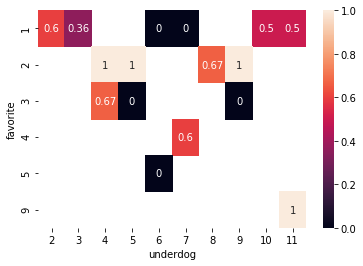

In [310]:
# What about round 4?
round4 = data.query('Round == 4')

favorites = [1, 2, 3, 4,5,6,7,9,10]
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round4[round4['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round4[(round4.favorite == favs[i]) & (round4.underdog == underdogs[i])].shape[0]
    upsets = round4[(round4.favorite == favs[i]) & (round4.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round4_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round4_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

In [304]:
round4_upsets.sort_values(by=['occurences'], ascending = False)

,favorite,underdog,upset_rate,occurences
0,1,2,0.400000,5.0
1,1,3,0.333333,3.0
4,1,7,0.333333,3.0
2,1,4,0.000000,2.0
8,2,3,0.500000,2.0
10,3,11,0.000000,2.0
3,1,5,0.000000,1.0
5,1,9,0.000000,1.0
6,1,10,0.000000,1.0
7,2,8,1.000000,1.0


In [305]:
round4_upsets['occurences'].agg('sum')

23.0

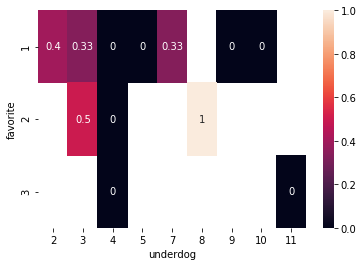

In [309]:
# What about round 5?
round5 = data.query('Round == 5')

favorites = [1, 2, 3]
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round5[round5['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round5[(round5.favorite == favs[i]) & (round5.underdog == underdogs[i])].shape[0]
    upsets = round5[(round5.favorite == favs[i]) & (round5.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round5_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round5_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

In [295]:
round5_upsets.sort_values(by=['occurences'], ascending = False)

,favorite,underdog,upset_rate,occurences
0,1,2,0.400000,5.0
1,1,3,0.333333,3.0
4,1,7,0.333333,3.0
2,1,4,0.000000,2.0
8,2,3,0.500000,2.0
10,3,11,0.000000,2.0
3,1,5,0.000000,1.0
5,1,9,0.000000,1.0
6,1,10,0.000000,1.0
7,2,8,1.000000,1.0


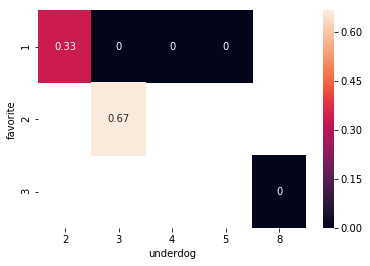

In [314]:
# What about round 5?
round6 = data.query('Round == 6')

favorites = [1, 2, 3]
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round6[round6['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round6[(round6.favorite == favs[i]) & (round6.underdog == underdogs[i])].shape[0]
    upsets = round6[(round6.favorite == favs[i]) & (round6.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round6_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round6_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

In [298]:
round6_upsets.sort_values(by=['occurences'], ascending = False)

,favorite,underdog,upset_rate,occurences
0,1,2,0.333333,3.0
4,2,3,0.666667,3.0
1,1,3,0.000000,1.0
2,1,4,0.000000,1.0
3,1,5,0.000000,1.0
5,3,8,0.000000,1.0


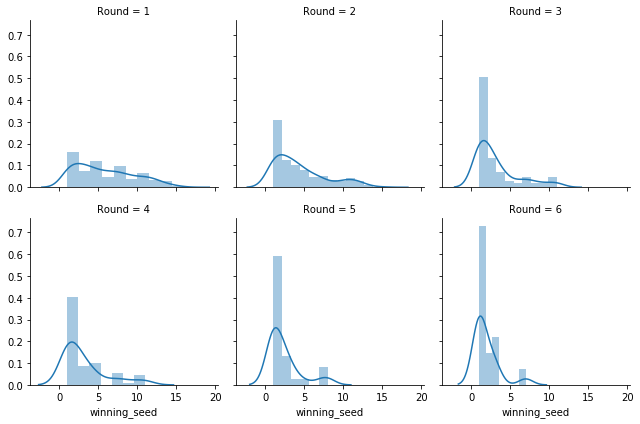

In [78]:
g = sn.FacetGrid(data, col="Round", col_wrap = 3)
g.map(sn.distplot, "winning_seed");

So what do we know so far? Well in this preliminary EDA we've shown that the most recent trend in the march madness tournament
shows an interesting trend where elite eight upsets are statistically more probable than in any other round of the tournament.
I'm going to hard code in the upset rates for this year's tournament to see how the historical trend matched up this year

In [57]:
rounds = [1,2,3,4,5,6]
upset_candidates = [32, 16, 8, 4, 2, 1]
actual_upsets = [12, 1, 3, 3, 1, 0]
bracket_2019 = pd.DataFrame(
    {'rounds': rounds,
     'upset_candidates': upset_candidates,
     'actual_upsets': actual_upsets,
     'historical_upset_pct': upset_pct['upset_pct']
    })
bracket_2019['upset_pct'] = bracket_2019['actual_upsets']/bracket_2019['upset_candidates']
bracket_2019['expected_upsets'] = bracket_2019['upset_candidates']*bracket_2019['historical_upset_pct']
bracket_2019

,rounds,upset_candidates,actual_upsets,historical_upset_pct,upset_pct,expected_upsets
Round,,,,,,
1,1,32,12,0.253906,0.3750,8.125000
2,2,16,1,0.289062,0.0625,4.625000
3,3,8,3,0.289062,0.3750,2.312500
4,4,4,3,0.515625,0.7500,2.062500
5,5,2,1,0.250000,0.5000,0.500000
6,6,1,0,0.272727,0.0000,0.272727


The upset percentages this year don't exactly line up with the historical trend we observed since 2003. Namely, the round of 32
displayed far fewer upsets than we've seen historically and the round of 64 saw about a 50% increase in the number of average 
upsets. Interestingly, the _expectated_ number of upsets for the tournament, given the historical distribution, is 18 and we 
actually observed 20 upsets. Let's look at the historical upset counts for each round of the tournament to get a sense of the
confidence intervals around these historical means.

In [58]:
data.query('Year >= 2003 & favorite != -1')[['upset', 'Year']].groupby(['Year']).agg('sum')

,upset
Year,
2003,21
2004,16
2005,19
2006,21
2007,12
2008,13
2009,16
2010,20
2011,20


(array([2., 1., 1., 0., 2., 1., 0., 1., 5., 3.]),
 array([12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]),
 <a list of 10 Patch objects>)

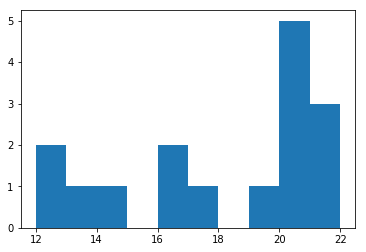

In [59]:
plt.hist(data.query('Year >= 2003 & favorite != -1')[['upset', 'Year']].groupby(['Year']).agg('sum')['upset'])

In [60]:
# compute standard deviation of upset statistic
data.query('Year >= 2003 & favorite != -1')[['upset', 'Year', 'Round']].groupby(['Year', 'Round']).agg('sum')['upset']

Year  Round
2003  1         8
      2         6
      3         2
      4         3
      5         1
      6         1
2004  1         4
      2         7
      3         2
      4         1
      5         2
      6         0
2005  1         8
      2         6
      3         4
      4         1
      5         0
2006  1         9
      2         5
      3         2
      4         4
      5         0
      6         1
2007  1         5
      2         5
      3         0
      4         2
      5         0
2008  1         8
      2         3
               ..
2013  5         0
      6         0
2014  1         8
      2         5
      3         4
      4         3
      5         2
      6         0
2015  1         5
      2         5
      3         1
      4         1
      5         0
2016  1        13
      2         3
      3         0
      4         3
      5         0
      6         1
2017  1         6
      2         4
      3         2
      4         2
      5         

In [61]:
# compute mean of upset statistic
data.query('Year >= 2003 & favorite != -1')[['upset', 'Year']].groupby(['Year']).agg('sum')['upset'].mean()

17.6875

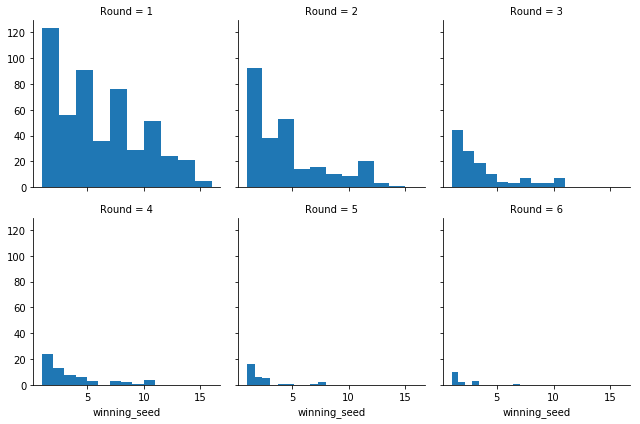

In [262]:
matchups = round2[(round2.favorite == favs[0]) & (round2.underdog == underdogs[0])].shape[0]
matchups

28

In [257]:
round2.columns


Index(['Year', 'Round', 'Region Number', 'Region Name', 'seed_1', 'score_1',
       'team_1', 'team_2', 'score_2', 'seed_2', 'winning_seed', 'favorite',
       'underdog', 'upset'],
      dtype='object')

In [269]:
favs


[1, 1, 2, 2, 3, 3, 4, 5, 6, 7]